## CutMix Implementation for Generating Datasets

#### Citation: 
Yun, S., Han, D., Oh, S., Chun, S., Choe, J., & Yoo, Y. (2019). CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features. In International Conference on Computer Vision (ICCV).

In [36]:
from ast import literal_eval
import os
import re
import pandas as pd
from glob import glob
from pathlib import Path
from collections import Counter 
import numpy as np
from sklearn.metrics import classification_report
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

pd.set_option('display.max_rows', 500)

In [25]:
# Retrieve the official labels of the CIFAR10 test dataset
# testset = torchvision.datasets.CIFAR10(root='../../data/cifar10/', train=False,
#                                        download=True)
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
# test_labels_CIFAR10 = testset.targets
# test_data_CIFAR10 = testset.data

# # Retrieve the official labels of the CIFAR10.1 test dataset
# test_labels_CIFAR101 =np.load('../data/cifar101/cifar10.1_v6_labels.npy')  
# test_data_CIFAR101 = np.load('../data/cifar101/cifar10.1_v6_data.npy')

Files already downloaded and verified
Files already downloaded and verified


#### Download the CIFAR10 dataset, normalize it, and place into a PyTorch DataLoader

In [414]:
normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                 std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
my_transforms = transforms.Compose([transforms.ToTensor(), normalize])

dataset = datasets.CIFAR10("data", download=True,
                 train=True, transform=transforms.ToTensor())

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(.0003 * dataset_size))
train_indices, val_indices = indices[split:], indices[:split]

dataloader = torch.utils.data.DataLoader(dataset, batch_size=int(len(val_indices)/3),
                                         sampler=SubsetRandomSampler(val_indices)) 
len(dataloader)

Files already downloaded and verified


4

#### Functions that implement CutMix

In [456]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


def cutmix_ds(beta, cutmix_prob, my_dataloader):

    results = []
    label_one = np.array([])
    label_two = np.array([])
    lambdas = np.array([])

    for i, (input, target) in enumerate(my_dataloader):
            # measure data loading time

             r = np.random.rand(1)
             if beta > 0 and r < cutmix_prob:
                # generate mixed sample
                lam = np.random.beta(beta, beta)
                rand_index = torch.randperm(input.size()[0])
                target_a = target
                target_b = target[rand_index]
                bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam)
                input[:, :, bbx1:bbx2, bby1:bby2] = input[rand_index, :, bbx1:bbx2, bby1:bby2]

                # adjust lambda to exactly match pixel ratio
                lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size()[-1] * input.size()[-2]))

                results.append(input)
                label_one = np.append(label_one, target_a.numpy())
                label_two = np.append(label_two, target_b.numpy())
                lambdas = np.append(lambdas, np.repeat(lam, len(target_b.numpy())))
                
    flat_results = [item for items in results for item in items]            
    my_labels = [(l1, l2, l) for l1, l2, l in zip(label_one, label_two, lambdas)]
    return flat_results, my_labels 

In [457]:
cm_data, cm_labels = cutmix_ds(1.0, 1.0, dataloader)

### Save and Load the PyTorch Data

In [462]:
torch.save(cm_data, './test_cutmix_beta1_prob1.pt')
np.save('./test_cutmix_beta1_prob1_labels.npy', cm_labels)

In [463]:
my_load = torch.load('./test_cutmix_beta1_prob1.pt')
my_label = np.load('./test_cutmix_beta1_prob1_labels.npy', allow_pickle=True)

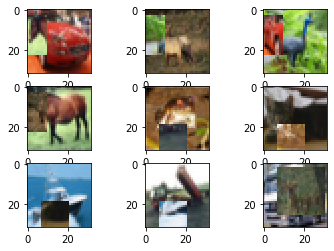

In [464]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    img = my_load[i]
    image=torch.squeeze(img)
    image=transforms.ToPILImage()(image)
    plt.imshow(image)
# show the figure
plt.show()

In [227]:
my_label

array([[array([9, 7, 2, 9, 9, 8, 4, 5, 6, 3, 0, 7, 9, 8, 1, 2, 2, 9, 3, 0, 5, 0,
       6, 5, 3, 3, 9, 1, 1, 5, 1, 9, 0, 4, 8, 6, 3, 0, 5, 5, 6, 8, 5, 1,
       9, 3, 6, 1, 7, 1, 2, 6, 6, 9, 5, 6, 3, 2, 7, 1, 7, 9, 1, 7, 5, 3,
       6, 0, 6, 6, 1, 9, 5, 6, 5, 7, 9, 8, 6, 0, 1, 6, 2, 0, 7, 3, 4, 1,
       0, 0, 3, 8, 1, 9, 6, 6, 4, 8, 1, 4, 7, 4, 6, 5, 3, 2, 7, 2, 9, 8,
       1, 1, 9, 5, 2, 3, 5, 2, 4, 7, 2, 5, 6, 6, 2, 9, 1, 2, 8, 9, 8, 9,
       1, 9, 4, 4, 6, 6, 2, 1, 7, 5, 3, 5, 4, 0, 6, 9, 1, 9, 7, 2, 3, 4,
       1, 6, 6, 8, 4, 7, 9, 1, 0, 6, 0, 7, 8, 1, 7, 4, 3, 3, 7, 7, 8, 4,
       2, 5, 9, 9, 2, 1, 2, 2, 7, 3, 0, 9, 9, 6, 4, 3, 3, 6, 1, 4, 8, 3,
       9, 1, 7, 1, 2, 3, 1, 6, 0, 6, 5, 8, 1, 8, 1, 5, 6, 6, 7, 8, 3, 1,
       1, 8, 4, 1, 6, 6, 1, 9, 2, 4, 4, 3, 0, 0, 5, 7, 7, 3, 2, 9, 0, 3,
       8, 5, 2, 4, 7, 1, 8, 8]),
        array([2, 3, 5, 2, 8, 3, 9, 4, 8, 6, 9, 6, 8, 1, 9, 6, 8, 8, 6, 6, 9, 4,
       7, 8, 7, 3, 9, 3, 1, 7, 4, 8, 0, 5, 0, 7, 3, 5, 5, 6, 1, 7, 2, 6,
  

### SCRATCH

<class 'torch.Tensor'>
<class 'PIL.Image.Image'>


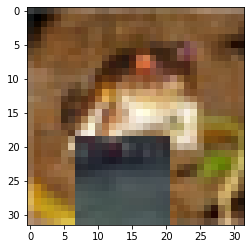

In [461]:
# To convert a tensor to an image
img = cm_data[4]
image=torch.squeeze(img)
print(type(image))
image=transforms.ToPILImage()(image)
print(type(image))
plt.imshow(image)